---

# Customer Lifetime Value calculation

---

## Introduction

Customer Lifetime Value (CLTV, LTV, CLV) is a very important metric for marketing and business. This is especially useful to calculate LTV for the e-commerce companies. Some experts consider that prevalence of the Cost to Acquare a Customer (CAC) over LTV is one of the major reasons of startups failures. In general, LTV is the total amount of profit received from a client during all the period of cooperation. If you know the LTV this helps to calculate ROI in more accurate way, improve the client retention strategy, client segmentation and clients support. 

In this notebook we will demonstrate how to explore the customers datasets and calculate LTV using diffrent ways to do this.

### Import modules

We will start with importing all necessary libraries. Pandas is used to work with data in the convenient format of dataframes. Numpy is a library for fast numerical calculations. Datetime library is used to work with dates. Matplotlib will be used to illustrate some things. Eventually, we are using openpyxl to load the datasets from the Excel file. 

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import openpyxl

### 1. Reading file with data

Below, we load the dataset (our internal dataset) and transform it to a convenient format.

In [2]:
wb = openpyxl.load_workbook('data.xlsx')
sheet = wb.get_sheet_by_name('Value by Year')

# Replace months names into its number
MONTHS = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

miss_rows = 14
transition_years = []
transition_months = []

for row_num, row in enumerate(sheet.iter_rows(row_offset=miss_rows)):
    if row_num == 0: # year row
        for index, cell in enumerate(row):
            if index > 3: 
                transition_years.append(int(cell.value))
    elif row_num == 1: # month row
        for index, cell in enumerate(row):
            if index > 3:
                transition_months.append(MONTHS[cell.value])
        transition_dates_amount = len(transition_months)
        df = pd.DataFrame(columns=['AccountID', 'Industry', 'TransitionYear', 'TransitionMonth', 'Value'])
    else: # transition activity for various accounts
        values = []
        for index, cell in enumerate(row):
            if index == 0:
                account_id = int(cell.value)
            elif index in (1,2):
                pass
            elif index == 3:
                industry = cell.value
            else:
                values.append(cell.value)
        if account_id > 140:
            break
        row_df = pd.DataFrame(
            data={ 
                'AccountID':       [account_id]*transition_dates_amount, 
                'Industry':        [industry]*transition_dates_amount,
                'TransitionYear':  transition_years,
                'TransitionMonth': transition_months,
                'Value':           values
            }
        )
        df = df.append(row_df)
        #print row_num, df.shape
print("DataFrame shape:", df.shape)

DataFrame shape: (7030, 5)


Display DataFrame (table) content

In [3]:
# Show the first 10 rows for AccountID == 140
df[df['AccountID'] == 140].head(10)

,AccountID,Industry,TransitionMonth,TransitionYear,Value
0,140,Other,7,2008,NaN
1,140,Other,8,2008,NaN
2,140,Other,9,2008,NaN
3,140,Other,10,2008,NaN
4,140,Other,11,2008,NaN
5,140,Other,12,2008,1.0
6,140,Other,1,2009,958.0
7,140,Other,2,2009,46.0
8,140,Other,3,2009,906.0
9,140,Other,4,2009,208.0


We can see that our dataframe consists of 5 columns (AccountID, Industry, TransitionMonth, TransitionYear, Value). There are 7030 rows in the dataframe. 

### 2. Calculate LTV without libraries

Let's now calculate LTV. Initially, we will compute total LTV by industry. We will not use any library first.

#### Total revenue by years

Now we group revenues by year. You can see the revenue dynamics below.

In [4]:
total_revenue = df.groupby('TransitionYear')['Value'].sum()
total_revenue

TransitionYear
2008     8401.0
2009    29270.0
2010    32111.0
2011    43982.0
2012    48157.0
2013    51276.0
2014    57372.0
2015    53858.0
2016    23871.0
Name: Value, dtype: float64

#### Accounts active in each year

Here we need to select 3 group of accounts. First group is the active accounts. Active accounts are  the accounts where the purchase was occured in the current year. New active accounts means the new customers. Gone active accounts are the accounts that were active in the previous years but there was no purchase in the current years. 

In [5]:
active_accounts = {
    year: df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value']))]['AccountID']
                .drop_duplicates().values 
    for year in range(2008, 2017)
}

# New active customers comparing with the previous year 
# (may contain those persons who have already been a customer, but who were not active one or more years before)
new_active_accounts = {
    year: df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value'])) & (~df['AccountID']
                 .isin(active_accounts[year-1]))]['AccountID']
                 .drop_duplicates().values 
    for year in range(2009, 2017)
}
new_active_accounts.update({ 2008: [] })

# New active customers who join first time
def join_sets(year):
    res = set()
    for i in range(2008, year):
        res = res | set(active_accounts[i])
    return res

# Accounts joined first time (and wich were not active anywhere previously)
pure_active_accounts = {
    year: df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value'])) & (~df['AccountID']
                   .isin(join_sets(year)))]['AccountID']
                   .drop_duplicates().values 
    for year in range(2009, 2017)
}
pure_active_accounts.update({ 2008: [] })

# How many accounts became not active
gone_active_accounts = {year: list(set(active_accounts[year-1]) - set(active_accounts[year])) for year in range(2009, 2017)}
gone_active_accounts.update({ 2008: [] })

Display calculated values in the bar chart:

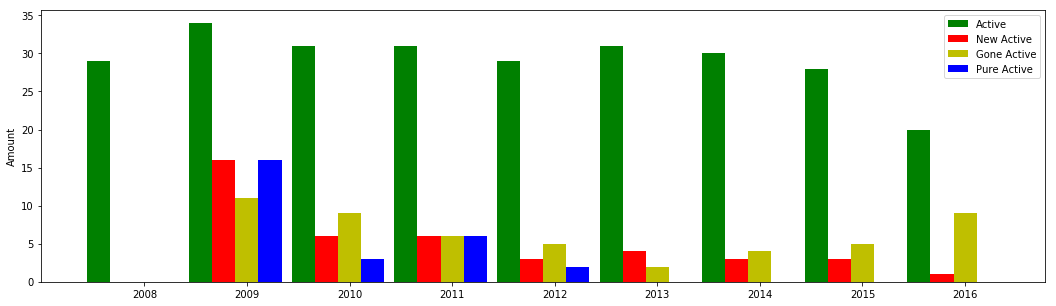

In [24]:
def get_amount(dictionary):
    keys = sorted(dictionary.keys())
    return [len(dictionary[key]) for key in keys]

N = len(range(2008, 2017))
ind = np.arange(N)
width = 0.225

fig, ax = plt.subplots(figsize=(18, 5))
active = ax.bar(ind, get_amount(active_accounts), width, color='g')
new_active = ax.bar(ind + width, get_amount(new_active_accounts), width, color='r')
gone_active = ax.bar(ind + 2*width, get_amount(gone_active_accounts), width, color='y')
pure_active = ax.bar(ind + 3*width, get_amount(pure_active_accounts), width, color='b')

ax.set_ylabel('Amount')
ax.set_xticks(ind + 2*width)
ax.set_xticklabels(sorted(active_accounts.keys()))

ax.legend((active[0], new_active[0], gone_active[0], pure_active[0]), ('Active', 'New Active', 'Gone Active', 'Pure Active'))
plt.show()

#### 1. Customer Retention Rate (CRR):
$$CRR = ((E-N)/S)\times100,$$

where 

* $E$ is the number of customers at the end of a period;
* $N$ is the number of new customers acquired during that period;
* $S$ is the number of customers at the start of that period.


Customer retention rate shows how many "old" active accounts remained active in the current year. We will use CRR in the LTV calculation.

In [7]:
E = {
    year: len(df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value']))]['AccountID']
               .drop_duplicates().values) 
    for year in range(2008, 2017)
}

print("Number of customers at the end of a period:\n", E)

N = {
    year: len(df[(df['TransitionYear'] == year) & (df['Value'] != 0) & (pd.notnull(df['Value'])) & (~df['AccountID']
               .isin(active_accounts[year-1]))]['AccountID']
               .drop_duplicates().values)
    for year in range(2009, 2017)
}
N.update({ 2008: 0 })

print()
print("Number of new customers acquired during that period:\n", N)

S = {
    year: len(df[(df['TransitionYear'] == year-1) & (df['Value'] != 0) & (pd.notnull(df['Value']))]['AccountID']
               .drop_duplicates().values) 
    for year in range(2009, 2017)
}

S.update({ 2008: len(df[(df['TransitionYear'] == 2008) & (df['TransitionMonth'] == 8) & (df['Value'] != 0) & 
                        (pd.notnull(df['Value']))]['AccountID'].drop_duplicates().values) })

print()
print("Number of customers at the start of that period:\n", S)

CRR = {}
for year in range(2008, 2017):
    CRR.update({year: (E[year] - N[year])/float(S[year])})
    
print()
print("CRR:", CRR)

Number of customers at the end of a period:
 {2008: 29, 2009: 34, 2010: 31, 2011: 31, 2012: 29, 2013: 31, 2014: 30, 2015: 28, 2016: 20}

Number of new customers acquired during that period:
 {2009: 16, 2010: 6, 2011: 6, 2012: 3, 2013: 4, 2014: 3, 2015: 3, 2016: 1, 2008: 0}

Number of customers at the start of that period:
 {2009: 29, 2010: 34, 2011: 31, 2012: 31, 2013: 29, 2014: 31, 2015: 30, 2016: 28, 2008: 10}

CRR: {2008: 2.9, 2009: 0.6206896551724138, 2010: 0.7352941176470589, 2011: 0.8064516129032258, 2012: 0.8387096774193549, 2013: 0.9310344827586207, 2014: 0.8709677419354839, 2015: 0.8333333333333334, 2016: 0.6785714285714286}


We can see, that the retention rate increased from 2009 year until 2013. However, in 2014-2016 the CRR dropped dramatically. This means that the company has some problems and the active clients refuse to cooperate further with the firm.

#### 2. Customer profit for each industry:

We want to calculate total LTV by industry. So, we need to have a dictionary with total profits by industry and year. Below we created such dictionary:

In [8]:
industries = df['Industry'].drop_duplicates().values
print("Industries:", industries)

ind_profit = {ind: {} for ind in industries}
for year in range(2008,2017):
    for ind in industries:
        x = df[(df['TransitionYear'] == year) & (df['Industry'] == ind)]['Value'].sum()
        ind_profit[ind].update({ year: 0 if np.isnan(x) else x })
        
print("Total profit:\n", ind_profit)

Industries: ['Other' 'S' 'M' 'EO' 'D' 'SC' 'G' 'C' 'T']
Total profit:
 {'Other': {2008: 895.0, 2009: 7762.0, 2010: 7258.0, 2011: 9063.0, 2012: 14761.0, 2013: 12103.0, 2014: 17103.0, 2015: 12497.0, 2016: 5374.0}, 'S': {2008: 5642.0, 2009: 15744.0, 2010: 19283.0, 2011: 27614.0, 2012: 24515.0, 2013: 31519.0, 2014: 31751.0, 2015: 33261.0, 2016: 14101.0}, 'M': {2008: 0.0, 2009: 0.0, 2010: 99.0, 2011: 122.0, 2012: 235.0, 2013: 102.0, 2014: 162.0, 2015: 40.0, 2016: 0.0}, 'EO': {2008: 846.0, 2009: 420.0, 2010: 1055.0, 2011: 854.0, 2012: 841.0, 2013: 966.0, 2014: 516.0, 2015: 517.0, 2016: 0.0}, 'D': {2008: 262.0, 2009: 1759.0, 2010: 1155.0, 2011: 2124.0, 2012: 2092.0, 2013: 1670.0, 2014: 2181.0, 2015: 1693.0, 2016: 1379.0}, 'SC': {2008: 705.0, 2009: 1564.0, 2010: 1189.0, 2011: 2828.0, 2012: 4185.0, 2013: 3034.0, 2014: 3067.0, 2015: 3344.0, 2016: 2083.0}, 'G': {2008: 0.0, 2009: 554.0, 2010: 337.0, 2011: 589.0, 2012: 559.0, 2013: 667.0, 2014: 592.0, 2015: 0.0, 2016: 0.0}, 'C': {2008: 18.0, 2009: 

#### 3. Calculate LTV:
$$LTV = \sum_{t=1}^n r^t\cdot\frac{P_t}{(1+d)^t}$$

where

* $t$ is a period, e.g. the first year(t=1), the second year(t=2)
* $n$ is the total number of periods the customer will stay before he/she finally churns
* $r$ is the retention rate/possibility
* $P_t$ is the profit the customer will contribute in the Period t
* $d$ is the discount rate

We are using the discounted cash flow model (DCF). According to this model, we should convert all our future cash flows (like profit) into the current, or present value. Future values are transformed into the present values by dividing the future value by the (1+discount rate). Discount rate is one or the most important values here, because it is difficult to choose it properly. Discount rate should be chosen in the way to take into account some important macroeconomic factors as well as own requirements of the economic unit. In our case we just set discount rate to be 10% (0.1). 

In [9]:
d = 0.1

CLV = {}
for ind in industries:
    CLV.update({ 
        ind: round(sum(CRR[year]**(i+1) * ind_profit[ind][year]/(1+d)**(i+1) for i, year in enumerate(range(2008, 2017))), 2) 
    })
    
print("CLV:", CLV)

CLV: {'Other': 22632.68, 'S': 61515.27, 'M': 198.82, 'EO': 3654.55, 'D': 3989.48, 'SC': 6710.76, 'G': 951.98, 'C': 411.69, 'T': 2306.28}


You can see the total LTV by industry computed above. The worst LTV is in the "C" industry, while the best LTV is in "Other" category of industries.

### 3. Calculate LTV using Lifetimes library

There is one good library for users analysis called [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes). We will use this library to explore our dataframe and to calculate individual LTVs by the independent customers.

First, we need to import a function which will create a summary table with useful statistics. Also, we need to change the format of date representation in the dataframe. Now, instead of separate year and month columns, we have single `TransitionDate` column. You can see top 5 records of the dataframe below.

In [25]:
from lifetimes.utils import summary_data_from_transaction_data

df_date = df.copy()
df_date = df_date[(df['Value'] != 0) & (pd.notnull(df['Value']))]
df_date['TransitionDate'] = df_date.apply(lambda x: datetime.datetime.strptime(str(int(x['TransitionYear'])) 
                                                          + str(int(x['TransitionMonth'])) + '1', "%Y%m%d").date(), axis=1)
df_date.drop(['TransitionYear', 'TransitionMonth'], axis=1, inplace=True)
df_date[df_date['AccountID'] == 140].head()

,AccountID,Industry,Value,TransitionDate
5,140,Other,1.0,2008-12-01
6,140,Other,958.0,2009-01-01
7,140,Other,46.0,2009-02-01
8,140,Other,906.0,2009-03-01
9,140,Other,208.0,2009-04-01


In [12]:
summary = summary_data_from_transaction_data(
    df_date, 
    customer_id_col='AccountID', 
    datetime_col='TransitionDate',
    monetary_value_col='Value'
)

print(summary.shape)
summary.head()

(56, 4)


,frequency,recency,T,monetary_value
AccountID,,,,
1,75.0,2861.0,2861.0,49.266667
6,63.0,2861.0,2861.0,181.682540
8,1.0,28.0,2646.0,270.000000
10,1.0,31.0,2861.0,157.000000
11,70.0,2373.0,2373.0,240.400000


Above, we can see the output of the `summary_data_from_transaction_data` function from the Lifetimes library. 


Frequency means the number of the *repeated* purchases. So, total number of purchases is the frequency + 1. 

T means the age of the customer. The age of the customer is the time between the first purchase and the end of the analysing period.

Recency is the age of the customer on the moment of the last purchase. So, it is the time between the first and last purchases. 

Below we filter out the records where the recency is 0 (no repeated purchases). 

In [14]:
returning_customers_summary = summary[summary['frequency']>0]
print(returning_customers_summary.shape)
returning_customers_summary.head()

(53, 4)


,frequency,recency,T,monetary_value
AccountID,,,,
1,75.0,2861.0,2861.0,49.266667
6,63.0,2861.0,2861.0,181.682540
8,1.0,28.0,2646.0,270.000000
10,1.0,31.0,2861.0,157.000000
11,70.0,2373.0,2373.0,240.400000


To calculate the LTV we will use Gamma-Gamma model. This model assumes that there is no relationship between the `monetary_value` and `frequency`. So, we need to check if this hypothesis is true enough:

In [15]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.288765
frequency,0.288765,1.000000


Here we fit the model:

In [17]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'], 
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 53 subjects, p: 0.92, q: 1.93, v: 238.28>


Now we calculate the average expected profit by client using the `summary` dataset:

In [18]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head())

AccountID
1      51.744819
6     182.529546
8     252.486719
10    196.354812
11    240.325816
dtype: float64


In [19]:
x = df[(df['Value'] != 0) & (pd.notnull(df['Value'])) & (df['AccountID'] == 1)]['Value']
x.values.sum()

3703.0

Compare the expected conditional average profit and the actual average profit:

In [20]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 202.02205261227527, Average profit: 185.64059403561106


Eventually, we are able to calculate customer lifetime value. In Lifetimes, we should use `customer_lifetime_value()` function. Also, there is a need to specify all necessary parameters. 

In [23]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit the BG model to the summary_with_money_value dataset
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=12, # months
    discount_rate=0.7
).head(10))

AccountID
1      57.205414
6     170.019202
8       0.028537
10      0.018356
11    297.473536
13     79.559016
14      1.758953
16     17.427550
17      0.002490
19     38.337719
Name: clv, dtype: float64


C:\Users\admin\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:182: RuntimeWarning: invalid value encountered in log
  ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))
C:\Users\admin\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:186: RuntimeWarning: invalid value encountered in log
  ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + \


## Conclusion

In this notebook we have described how we can calculate Customer Lifetime Value using Lifetimes library as well as only with Python and common libraries like Numpy and Pandas. Also, there were introduced some other useful tools of the Lifetimes library. Anybody can use the code from here in order to compute the LTV on their data. All is needed is to keep the same data format.

*Tags: Customer Lifetime Value, Lifetimes, Python, business metrics, data analytics.*